# Tutorial 5 - Getting better results with SageMaker training jobs

In the last tutorial, we trained and evaluated the first model on a small sample of data. While it is possible to train a model within [Sagemaker Studio](https://www.youtube.com/watch?v=uQc8Itd4UTs&list=PLhr1KZpdzukcOr_6j_zmSrvYnLUtgqsZz) it's better to use a Sagemaker training job instead. Sagemaker training jobs have several advantages over a normal notebook. To name few of them:

- provide you with a nice overview of all the training you ran
- automatically store the results of a training run (metrics, [logs](https://console.aws.amazon.com/cloudwatch) and models)
- do not automatically shut down after a few hours (which we enabled in the notebooks)
- allows running multiple training jobs in parallel (if you have sufficient GPUs allocated)

In this notebook, we will convert the approach from tutorial 4 into a Sagemaker training job and train our model on the full data set. During the training, the logs are sent to [Cloudwatch](https://console.aws.amazon.com/cloudwatch) - AWS monitoring service. After the training is completed, the model is saved and automatically uploaded to S3. From there we'll retrieve the model and evaluate it.

**NOTE: We will NOT need a GPU for this tutorial notebook. Pick a non-GPU instance type to save costs.**

## Setup

First, we need to import required libraries and functions.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os  

In [4]:
os.getcwd() 

'/root/data/experiments/exp_2023-07-09_batch_size8_sr22050'

In [5]:
import sys                                                                             # Python system library needed to load custom functions
import numpy as np                                                                     # for performing calculations on numerical arrays
import pandas as pd                                                                    # home of the DataFrame construct, _the_ most important object for Data Science
import seaborn as sns                                                                  # additional plotting library
import matplotlib.pyplot as plt                                                        # allows creation of insightful plots
import os                                                                              # for changing the directory

import sagemaker                                                                       # dedicated sagemaker library to execute training jobs
import boto3                                                                           # for interacting with S3 buckets

from sagemaker.huggingface import HuggingFace                                           # for executing the trainig jobs
from sklearn.metrics import precision_recall_fscore_support, accuracy_score             # tools to understand how our model is performing

#sys.path.append('')                                                               # Add the source directory to the PYTHONPATH. This allows to import local functions and modules.
from config import DEFAULT_BUCKET, DEFAULT_REGION  
from gdsc_utils import create_encrypted_bucket, download_and_extract_model, PROJECT_DIR # functions to create S3 buckets and to help with downloading models. Importing our root directory
from gdsc_eval import plot_confusion_matrix                                             # function for creating confusion matrix                                     # importing the bucket name that contains data for the challenge and the default region
os.chdir(PROJECT_DIR)                                                                   # changing our directory to root

# Running the Training Script

The training job will run on a virtual machine (called an instance) in the AWS cloud. An overview of all your training jobs can be found in the [AWS console](https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs) (you may have to change the region) after you logged into your account. You can also navigate directly to *Amazon SageMaker > Training > Training jobs* and click on the name of the latest training job.

To start, we need to set the name of our experiment. Keep in mind that every experiment should have a unique name. Since we advise you to use a separate Python script for each training, we'll use the name of the training script as the name of the experiment.

In [6]:
entry_point = 'baseline_ast_train.py'
exp_name = entry_point.split('.')[0].replace('_', '-')  # AWS does not allow . and _ as experiment names
exp_name

'baseline-ast-train'

Next, we need to define the AWS settings for the job.

In [7]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
role = sagemaker.get_execution_role()

We will also need to download the data to train a model. Luckily, Sagemaker has built-in functionality for this. 
Via the ```input_channels``` parameter we can specify multiple S3 locations. The contents are downloaded in the training job and made available under the provided name (dictionary key).
In the example below, Sagemaker will download the complete content of the training data bucket, store it on the instance and, save its location in an environment variable called ```SM_CHANNEL_DATA```.<br>
You can define up to 20 different channels.

In [8]:
DEFAULT_BUCKET

'gdsc.data.public.us-east-1'

Below is the required structure in our **S3_bucket** that needs to be followed to create the HuggingFace dataset without any issues. The *metadata.csv* file should contain two columns:
- file_name - the name of the file,
- label - the ground truth label for that file.

As we do not have labels for the test set, we only include the *file_name* column in the *metadata.csv* in the test directory.

```
S3_bucket/
    └── data/
        |── labels.json
        └── train/
            |── train_file_1.wav
            |── train_file_2.wav
            |── ...
            |── metadata.csv
        └── val/
            |── val_file_1.wav
            |── val_file_2.wav
            |── ...
            |── metadata.csv
        └── test/
            |── test_file_1.wav
            |── test_file_2.wav
            |── ...
            |── metadata.csv
```

In [9]:
DEFAULT_BUCKET = 'sagemaker-us-east-1-292159885427/original_dataset'

In [10]:
input_channels = {    
    "data": f"s3://{DEFAULT_BUCKET}"    
}
input_channels

{'data': 's3://sagemaker-us-east-1-292159885427/original_dataset'}

We also specify where Sagemaker should store the results of the training job - i.e. the weights of the trained model. You will also see the link at the bottom of the training job overview page. If you already created a specific bucket for that purpose change ```s3_output_location``` variable to this bucket name

In [11]:
# We need to create our own s3 bucket if it doesn't exist yet:
sagemaker_bucket = f"sagemaker-{DEFAULT_REGION}-{account_id}"
create_encrypted_bucket(sagemaker_bucket)

s3_output_location = f"s3://{sagemaker_bucket}/{exp_name}"
s3_output_location

's3://sagemaker-us-east-1-292159885427/baseline-ast-train'

Using the <b>argparse</b> module in our training script, we can define the parameters that will be passed to the script. These parameters can include hyperparameters sent by the user, which are passed as command-line arguments to the script. Please go to the *baseline_ast_train.py* file located in the *src* and inspect the lines from 114 to 130, to see the whole list of possible arguments that you can pass to the script we've prepared.

In [12]:
hyperparameters={
    "epochs":10,                                                   # number of training epochs
    "patience":3,                                                  # early stopping - how many epoch without improvement will stop the training
    "train_batch_size":4,                                          # training batch size
    "model_name":"MIT/ast-finetuned-audioset-10-10-0.4593",        # name of the pretrained model from HuggingFace
    "train_dir":"train",                                           # folder name with training data
    "val_dir":"val",                                               # folder name with validation data
    "test_dir":"test",                                             # folder name with test data
    "train_dataset_mean":-8.141991150530815,                       # mean value of spectrograms of our resampled data 
    "train_dataset_std":4.095692486358449,                         # standard deviation value of spectrograms of our resampled data
    "learning_rate":2e-5
}

Finally, we need to specify which metrics we want Sagemaker to automatically track. For this, we need to set up [regular expressions](https://en.wikipedia.org/wiki/Regular_expression) that will be applied to the logs.
The corresponding values will then be stored and made visible in the training job.

In [13]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

After all the necessary preparations, we are now ready to define a *SageMaker Estimator* which handles end-to-end Amazon SageMaker training and deployment tasks. While there are multiple available Estimators in SageMaker, we need to use the one that is compatible with our training script, so in our case, we will use the ```HuggingFace``` estimator.

- SageMaker takes care of installing all the necessary libraries for the training job, but if there are any additional modules you want to use in the job, you can define them in ```src/requirements.txt```.
- All the steps defined in our entry point will run during the training jobs. Therefore, if you want to change anything in the training process, you should define it in the Python script.
- To start the job, we can call ```estimator.fit().``` With this command, the whole content of the src directory will be uploaded to the training instance. Therefore, if you want to use any additional functions, you should define them in src.
- Note that interrupting the training job in the notebook won't stop it. If you don't want your job to finish, you have to stop it in the UI. Also, you can run only one job at a time.
- When your training job is completed, your model will be stored as a .tar file in S3. The ```s3_output_location``` determines the location, and you can find it in the folder ```<your-training-job>/output```. You can download your model from there and test it locally. If there is no output folder, make sure to check the logs in the AWS console, as your training job may have failed.

In [14]:
INSTANCE_TYPE = "ml.g4dn.xlarge" 
SOURCE_DIR = "exp_2023-07-09_batch_size8_sr22050"

In [15]:
image_uri = '954362353459.dkr.ecr.us-east-1.amazonaws.com/sm-training-custom:latest'

huggingface_estimator = HuggingFace(
    entry_point=entry_point,                # fine-tuning script to use in training job
    source_dir=SOURCE_DIR,           # directory where fine-tuning script is stored. This directory will be downloaded to training instance
    instance_type=INSTANCE_TYPE,         # instance type - ml.g4dn.xlarge is a GPU instance so the training will be faster 
    output_path = s3_output_location,       # outputbucket to store our model after training
    instance_count=1,                       # number of instances. We are limited to 1 instance
    role=role,                              # IAM role used in training job to acccess AWS resources (S3)
    image_uri = image_uri,                  # passing our custom image with the required libraries
    py_version="py310",                     # Python version 
    hyperparameters=hyperparameters,        # hyperparameters to use in training job
    metric_definitions = metric_definitions # metrics we want to extract from logs. It will be visible in SageMaker training job UI
)

After we created the estimator, we will need to call the *fit* method to start the training job. As this might take a while, we can set ```wait=False``` so our notebook will not wait for the training job to finish and we can continue working, but for the sake of the tutorial let's set it to ```True```.

In [16]:
huggingface_estimator.fit(input_channels, wait=True)

Using provided s3_resource


INFO:sagemaker:Creating training-job with name: sm-training-custom-2023-07-09-20-02-33-049


2023-07-09 20:02:33 Starting - Starting the training job...
2023-07-09 20:02:49 Starting - Preparing the instances for training......
2023-07-09 20:03:55 Downloading - Downloading input data....................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-09 20:07:13,842 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-09 20:07:13,858 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-09 20:07:13,866 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-09 20:07:13,874 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-09 20:07:15,241 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-09 20:07:15,265 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-07-09

In [17]:
# save the model location to the filesystem so that we can use it later
model_location = f'{s3_output_location}/{huggingface_estimator._hyperparameters["sagemaker_job_name"]}/output/model.tar.gz'
print(model_location)

s3://sagemaker-us-east-1-292159885427/baseline-ast-train/sm-training-custom-2023-07-09-20-02-33-049/output/model.tar.gz


In [18]:
#model_location = 's3://sagemaker-us-east-1-292159885427/baseline-ast-train/sm-training-custom-2023-06-21-12-27-40-579/output/model.tar.gz'

In [19]:
# saving the csv file under the appropriate location. Create the folder if it doesn't exist 
model_folder_path =f"models/{huggingface_estimator._hyperparameters['sagemaker_job_name']}"
# model_folder_path = 'sm-training-custom-2023-06-21-12-27-40-579'

if not os.path.exists(model_folder_path):
    os.makedirs(model_folder_path)
    
with open(f'{model_folder_path}/model_location.txt', 'w+') as f:
    f.write(model_location)

One important question that we haven't answered to far is *How can I see how the training is doing?* After all you need see if there are any issues or if the training is going well.
This can be done as follows:

1. Go to the AWS Console
2. Search for AWS Sagemaker and go to the Service
3. On the left panel click on Training -> Training Jobs
4. Your training job should the one at the very top. Click it.
5. The details page has a link *View logs* in the *Monitor* section (scroll down). Click this to see the logs. 

The default configuration for this tutorial will train your model for approximately 7 epochs. This should take less than 2 hours and give you an indication if an idea is working or not.
Training for longer does not necessary help. **To save time and money we suggest to start with a few epochs and only train models for longer where you are certain that there is a significant benefit.** After all, you only have a limited budget.

## Key takeaways:

- We utilize **SageMaker Training jobs** to train our model, which takes place on a separate virtual machine (instance). The steps outlined in the training script (baseline_ast_train.py) will be executed there. If you wish to alter the training process, modify the training script accordingly (and we'd suggest you to save it under a new name).
- You can monitor the job's progress in the [*SageMaker Trainings UI*]('https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs'). In the **Monitoring** section, you can keep track of metrics during the training process.
- If you want to stop the training, you must do so in the [*SageMaker Trainings UI*]('https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs'). Stopping the job in the notebook alone will not suffice.
- You can alter the input data to use your own S3 bucket if you have created the dataset differently.
- Keep in mind that you can experiment with the **hyperparameters** of the model.
- Since we employ a GPU instance for the training process, bear in mind that we pay for each second of training. If you do not see any improvement in longer trainings (more epochs), focus on other tasks such as data preprocessing.

# A new submission with our newly trained model!

After the training job is finished - which should take in our case less than 2 hours! - you can download the results of the training job.

*Note: Check the AWS training job console to see the status of your training job*

First we need to specify where the results where stored. We stored the model location to the local filesystem, we only need to read it. If that didn't work, make sure to check the Sagemaker Training section in the AWS console. The model location will look similar to this:```s3://sagemaker-us-east-1-192475648101/train/huggingface-pytorch-training-2023-05-05-13-44-42-427/output/model.tar.gz```

In [20]:
# read the model location from the filesystem
with open(f'{model_folder_path}/model_location.txt', 'r') as f:
    model_location = f.read()

We prepared a custom function that downloads the results to our local directory. 

In [21]:
local_model_dir = download_and_extract_model(model_uri=model_location, local_dir='models')
local_model_dir

'models/sm-training-custom-2023-07-09-20-02-33-049'

To confirm that everything ran correctly, please navigate to the *models* directory. There, you should find the following files:

- *checkpoint-###* folders
- *prediction_val.csv*
- *prediction_test.csv*
- *model.tar.gz*

The checkpoint folders contain the model's weights, which can be loaded to generate predictions from different epochs. In the training script, we set ```load_best_model_at_end``` to **True**, which ensures that the model is loaded with the best checkpoint based on the validation loss. After loading the checkpoint, we generated predictions for both the validation and test sets, which can be found in the same directory where you extracted the model.

With everything set up, let's proceed to loading the test set predictions!

In [22]:
test_preds = pd.read_csv(f'{local_model_dir}/prediction_test.csv', index_col = False)
test_preds.head()

,file_name,predicted_class_id
0,0.wav,14
1,1.wav,60
2,10.wav,26
3,100.wav,56
4,101.wav,57


You can upload this file to the [GDSC website](https://gdsc.ce.capgemini.com/) what score did you get? Do you see a big difference between this model and the one trained on a small sample of data?

Please keep in mind that the submission file must adhere to the following format:

- A *file_name* column, indicating the file for which the prediction was generated
- A *predicted_class_id* column, containing the predicted ID for that file.

**If the submission file deviates from this format, there is a risk of encountering problems when running the evaluation function.**

# Error analysis on Validation set

Error analysis is an essential part of machine learning, as it helps us to identify and diagnose problems that may arise during the training and testing stages of a machine learning model. By analyzing the errors, we can gain insights into the performance of the model, and we can make informed decisions about how to improve its accuracy and effectiveness.

There are several reasons why error analysis is necessary in machine learning and how can it help with improving model performance:

- Identify the sources of errors: By analyzing the errors, we can identify the sources of errors, such as data quality issues. This helps us to understand where the model is failing and how we can improve it.

- Improve model accuracy: Error analysis can help us to fine-tune the model by identifying which features or parameters are causing errors, and adjusting them to improve accuracy.

- Evaluate model performance: Error analysis helps us to evaluate the performance of the model against the desired outcome. It also allows us to compare the performance of different models and select the best one for our use case.

As we prepared predictions on the validation set we can use them for the error analysis. Let's give it a try! 


First of all we should load ```prediction_val.csv``` file and inspect it

In [23]:
val_preds = pd.read_csv(f'{local_model_dir}/prediction_val.csv', index_col = False)
val_preds.head()

,label,file_name,predicted_class_id,loss
0,0,Achetadomesticus_XC751734-dat001-055_edit1.wav,0,0.001234
1,0,Achetadomesticus_XC751734-dat001-055_edit2.wav,0,0.002963
2,0,Achetadomesticus_XC751734-dat001-055_edit3.wav,0,0.002078
3,0,Achetadomesticus_XC751734-dat001-055_edit4.wav,0,0.028004
4,0,Achetadomesticus_XC751736-dat001-057.wav,0,0.023864


This dataframe contains two additional columns that will be useful for Error Analysis:

- label - the ground truth label
- loss - the degree to which the model's prediction differs from the actual class

Before looking in depth at the loss values let's use our function imported from the *gdsc_eval.py* module to generate a **Confusion matrix** plot, which will provide greater insight into the model's performance for specific classes. 

Note from the docstring in the *gdsc_eval.py* that the last argument tells us if we want to normalize the values of the matrix over the true labels, predicted labels, the whole population or just give absolute values. Try to plot the confusion matrix with different normalizations and see if you can understand what do they mean. If you feel like something is not clear - post a comment on the Team's channel and start a conversation!

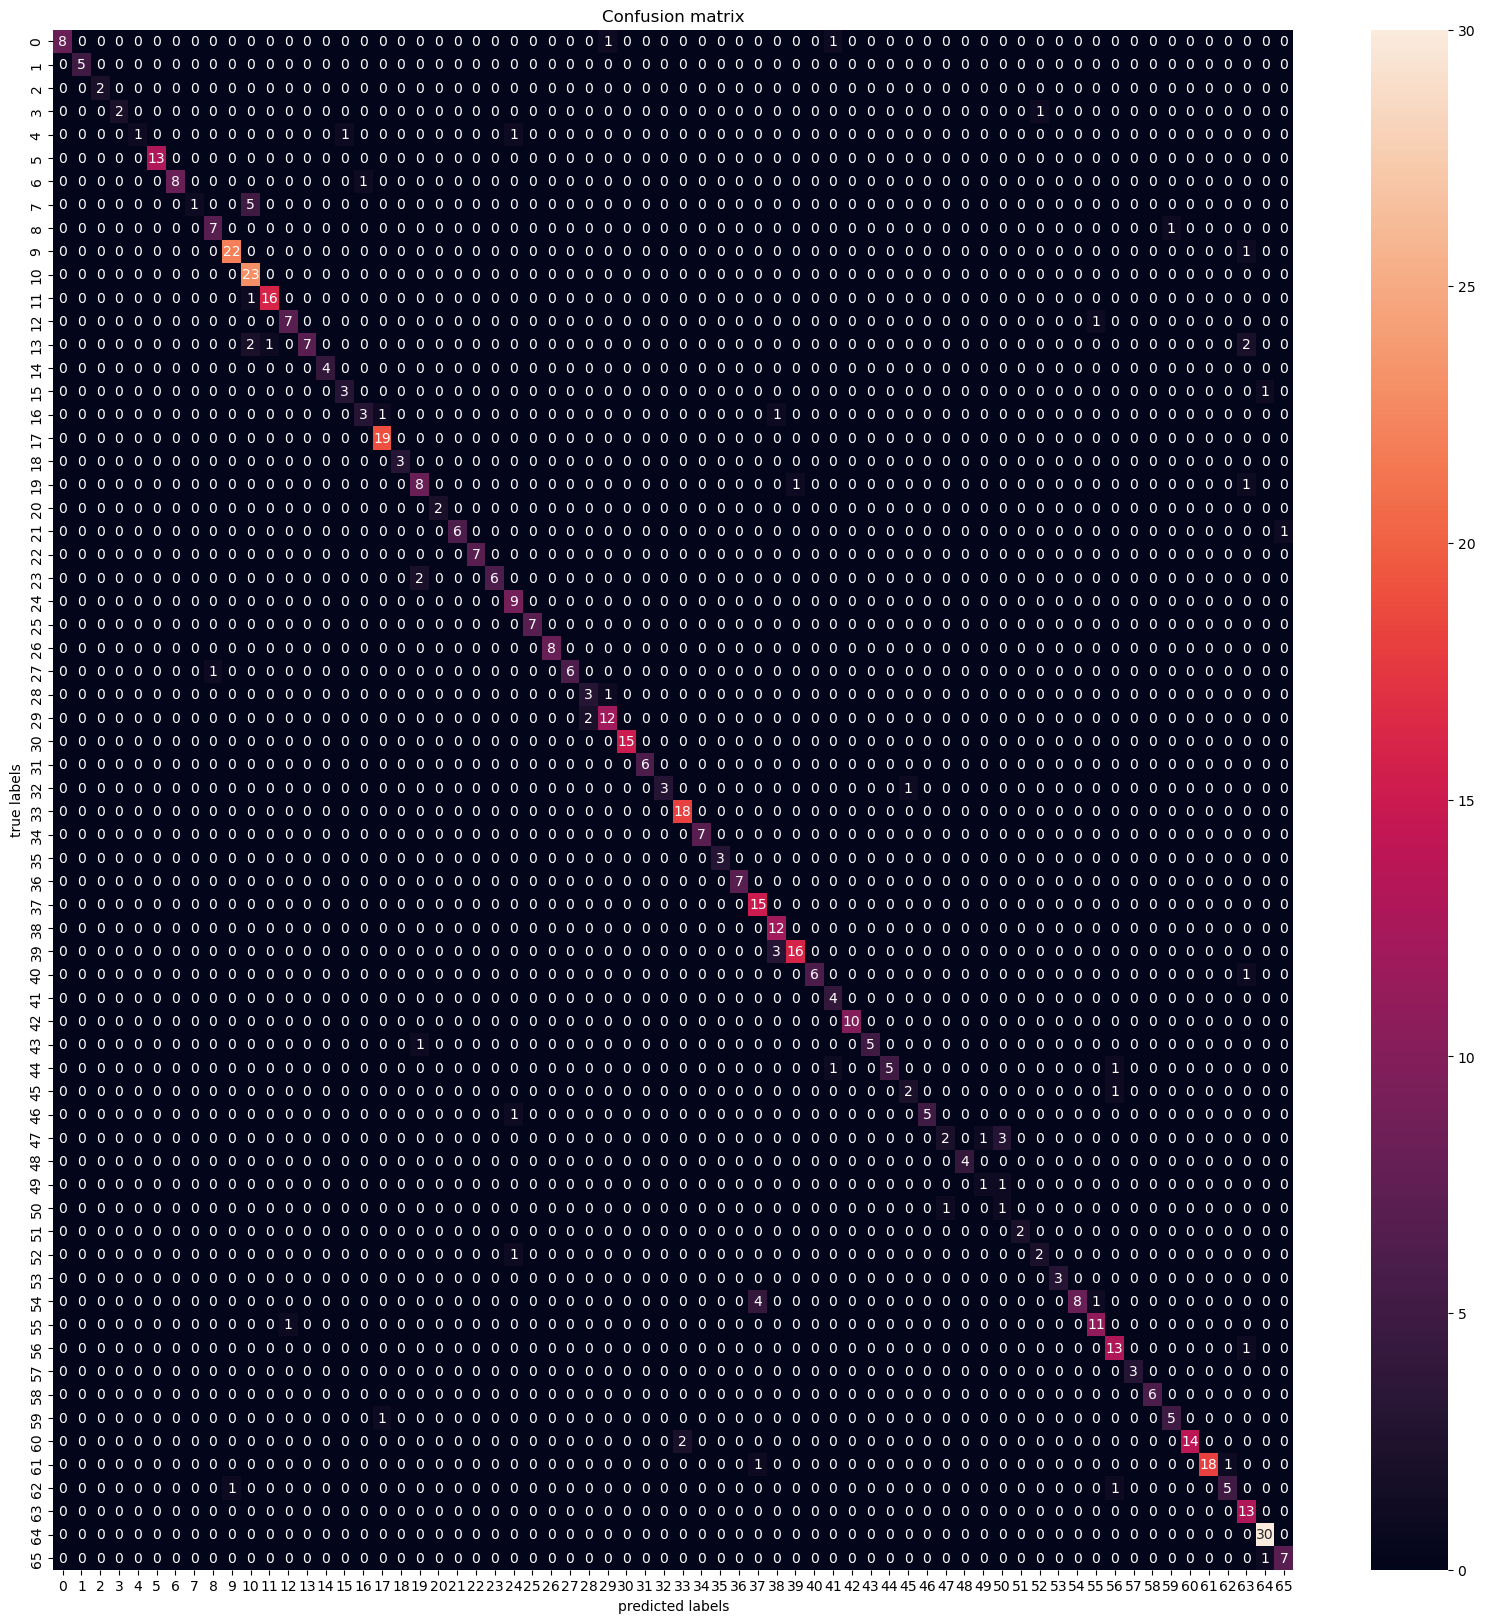

In [24]:
plot_confusion_matrix(val_preds['label'], val_preds['predicted_class_id'], normalize=None)

While the majority of the classes are accurately classified, there are a few that remain misclassified. Additionally, the model appears to have difficulty distinguishing between certain classes, would you be able to identify them? Maybe they are similar to each other?

We will now examine the losses for individual predictions. Generally speaking, the model's confidence in a given prediction increases as the loss decreases. Let's see which are the top 10 classes with the highest loss values!

In [25]:
# Classes sorted by the highest sum of loss
(
    val_preds.groupby("label")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
label,13.00,54.00,7.00,44.00,47.00,60.00,61.00,39.00,45.00,11.00
count,12.00,13.00,6.00,7.00,6.00,16.00,20.00,19.00,3.00,17.00
mean,2.85,1.85,3.20,2.09,2.40,0.88,0.49,0.47,2.79,0.49
sum,34.25,24.09,19.18,14.60,14.42,14.01,9.82,8.88,8.36,8.26


Since we only have a limited number of examples for certain classes, it might be more meaningful to focus on the average loss value instead. This approach could provide a more accurate representation of the model's performance for those classes with minimal validation examples.

In [26]:
# Classes sorted by highest mean of loss
(
    val_preds.groupby("label")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
label,7.00,49.00,13.00,45.00,47.00,44.00,28.00,54.00,3.00,52.00
count,6.00,2.00,12.00,3.00,6.00,7.00,4.00,13.00,3.00,3.00
mean,3.20,2.90,2.85,2.79,2.40,2.09,1.94,1.85,1.64,1.11
sum,19.18,5.79,34.25,8.36,14.42,14.60,7.74,24.09,4.92,3.32


The above tables give us an idea which classes are the most problematic. To investigate this further, we suggest plotting the examples with the highest loss and some of the examples of the class that the files were missclassified with. Try to identify any patterns or issues within the data. It is possible that this could be related to the quality of the data, and further analysis may be required.

## Exercises:

- Conduct your own Error Analysis based on the validation dataset predictions. Explore classes with the highest and lowest losses, and visualize spectrograms of these classes using the functions from the 2nd tutorial on EDA. Identify any classes that the model is consistently misclassifying and investigate whether these classes are similar to each other.
- Experiment with different hyperparameters during the training process to see how they affect model performance.
- Check out the [HuggingFace model Hub]('https://huggingface.co/models?pipeline_tag=audio-classification&sort=downloads'), where you can test out various audio classification models.

# What's next?

Phew! That was a long journey! From analyzing the metadata to getting first results. But the work is not yet done - honestly it has just started! You may wonder how to improve the results we have obtained. Well, there are few possibilities:

## Different preprocessing

Maybe it's worth to go back to the documentation of the [ASTFeatureExtractor](https://huggingface.co/docs/transformers/main/en/model_doc/audio-spectrogram-transformer#transformers.ASTFeatureExtractor). There are some hyperparameters that you can tweak like *max_length* of the file taken as the input.

## Data Augmentation

In the gdsc docker image provided by us you will find libraries like [torchaudio](https://pytorch.org/audio/stable/index.html) and [librosa](https://librosa.org/doc/main/index.html). Thsoe serve you the purpose of augmenting your dataset with use of various preprocessing steps. Maybe after inspecting the missclassifications you will come up with different methods for tweaking some audio features of the arrays?

Just please note that only the torchaudio library works with GPU, librosa will work only with CPU, which will make your training much slower.

## Other models

The AST model is not the only one out there. Try to inspect other architectures. Maybe one of them will be the winning one! Here are two example sources you can inspect (feel free to find more!):

#### Hugging Face Model Hub

The [Hugging Face Model Hub](https://huggingface.co/models?pipeline_tag=audio-classification&sort=downloads) has a variety of different models. Try to inspect few of them.  

#### Papers with code

The Papers with code site offers benchmarks of different models on different datasets. Here is an example of [benchmarking models on AudioSet dataset](https://paperswithcode.com/sota/audio-classification-on-audioset). This may be a bit advanced, but you can try to implement the code found in the repositories for a model that gives high scores.